C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


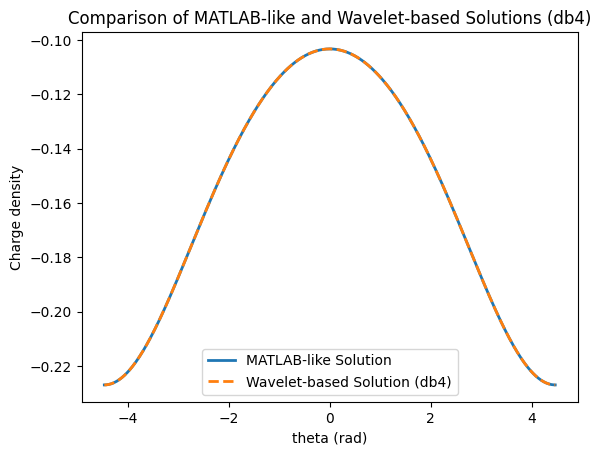

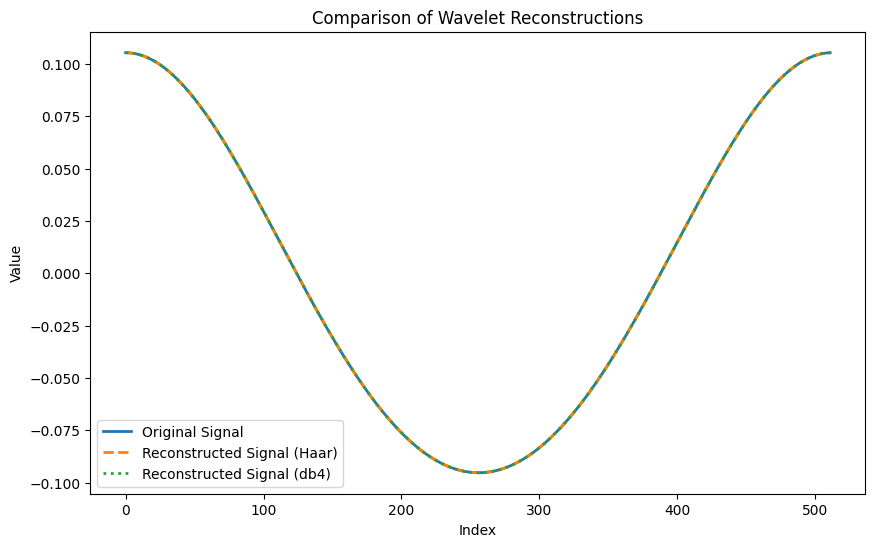

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Parameters
ro0 = 1
ro1 = -1
n = 512
h = 2 * np.pi / n
a = 1
d = 10

# Pre-computations
I = 4 * (np.log(2) * np.sin(h / 2) + 2 * (np.sin(h / 2) * np.log(np.sin(h / 2)) - np.sin(h / 2)))
B = a * np.log(a) - a / 2 * np.log(2 * a**2)
A = 2 * h * B

# Initialize arrays
teta = np.zeros(n)
f = np.zeros(n)
k = np.zeros(n)
mat = np.zeros((n, n))

# Calculate teta, f, and k
for i in range(n):
    teta[i] = i * h
    f[i] = ro0 * (np.log(d) - 0.5 * np.log(a**2 + d**2 - 2 * a * d * np.cos(teta[i])))

    if i == 0:
        k[i] = A - a / 2 * I
    else:
        k[i] = B - a / 2 * (np.log(2 * np.sin(teta[i] / 2)))
        if i == 1 or i == n - 1:
            k[i] *= h / 3
        else:
            k[i] *= 2 * h / 3 * (1 + i % 2)

# Construct the matrix mat
for i in range(n):
    for j in range(n):
        mat[i, j] = k[(j - i + n) % n]
# Solve the system in the physical domain (MATLAB-like approach)
f_physical = -f
ros_physical = np.linalg.solve(mat, f_physical)

# Normalize and correct the solution (MATLAB-like approach)
su_physical = np.sum(ros_physical)
ros_physical = -su_physical / n + ros_physical + ro1 / (2 * np.pi * a)

# Solve the system using the wavelet-based approach (using db4 wavelet)
f_wavelet = pywt.wavedec(f, 'db4', level=int(np.log2(n)))
f_processed = pywt.waverec(f_wavelet, 'db4')[:n]
f_processed = -f_processed
ros_wavelet = np.linalg.solve(mat, f_processed)

# Normalize and correct the solution (wavelet-based approach)
su_wavelet = np.sum(ros_wavelet)
ros_wavelet = -su_wavelet / n + ros_wavelet + ro1 / (2 * np.pi * a)

# Prepare for plotting
x = np.pi / 180 * (np.arange(1, n + 2) - n / 2 - 1)
ros_physical = np.append(ros_physical, ros_physical[0])
ros_wavelet = np.append(ros_wavelet, ros_wavelet[0])

# Plot the results
plt.plot(x, ros_physical, linewidth=2, label='MATLAB-like Solution')
plt.plot(x, ros_wavelet, '--', linewidth=2, label='Wavelet-based Solution (db4)')
plt.ylabel('Charge density')
plt.xlabel('theta (rad)')
plt.legend()
plt.title('Comparison of MATLAB-like and Wavelet-based Solutions (db4)')
plt.show()

# Compare wavelet coefficients
f_wavelet_haar = pywt.wavedec(f, 'haar', level=int(np.log2(n)))
f_wavelet_db4 = pywt.wavedec(f, 'db4', level=int(np.log2(n)))

# Compare reconstructed signals
f_reconstructed_haar = pywt.waverec(f_wavelet_haar, 'haar')[:n]
f_reconstructed_db4 = pywt.waverec(f_wavelet_db4, 'db4')[:n]

plt.figure(figsize=(10, 6))
plt.plot(f, label='Original Signal', linewidth=2)
plt.plot(f_reconstructed_haar, '--', label='Reconstructed Signal (Haar)', linewidth=2)
plt.plot(f_reconstructed_db4, ':', label='Reconstructed Signal (db4)', linewidth=2)
plt.legend()
plt.title('Comparison of Wavelet Reconstructions')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

